In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
# setting up the constants

# BATCH_SIZE = 32 
BATCH_SIZE = 32
IMAGE_SIZE_H = 405
IMAGE_SIZE_W = 720
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "H-pylori",
    shuffle=True,
    image_size=(IMAGE_SIZE_H, IMAGE_SIZE_W),
    batch_size=BATCH_SIZE
)

Found 4629 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['Negative_case', 'Positive_case']

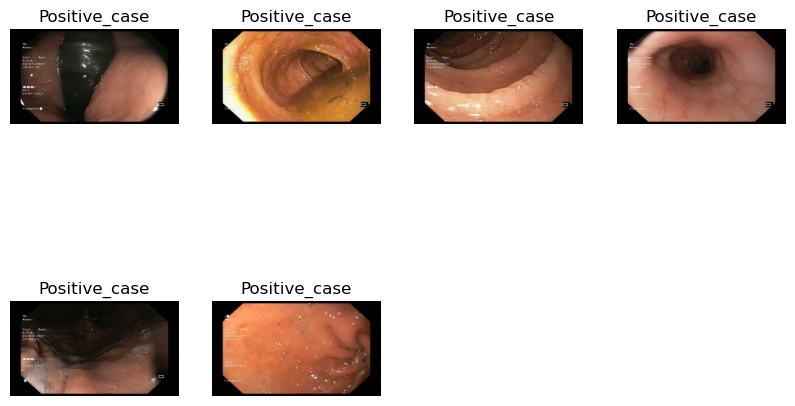

In [6]:
# visualizing some images

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

116

In [10]:
len(val_ds)

14

In [11]:
len(test_ds)

15

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
# Creating a Layer for Resizing and Normalization

#to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
#This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.
#somone can supply an image that is not (256,256) and this layer will resize it

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE_H, IMAGE_SIZE_W),
  tf.keras.layers.Rescaling(1./255),
])

In [14]:
#boost the accuracy of our model by augmenting the data

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [15]:
# Applying data augmentation to train dataset

# train_ds = train_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
#the model is CNN coupled with a Softmax activation in the output layer. 
# Added the initial layers for resizing, normalization and Data Augmentation.
input_shape = (BATCH_SIZE, IMAGE_SIZE_H, IMAGE_SIZE_W, CHANNELS)
n_classes = 3

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMAGE_SIZE_H, IMAGE_SIZE_W, CHANNELS)),
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),                                # Dropout layer for regularization (Prevent overfitting)
    layers.Dense(n_classes, activation='softmax'),
])

#model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 405, 720, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 403, 718, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 403, 718, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 201, 359, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 199, 357, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 199, 357, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 99, 178, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 97, 176, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 97, 176, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 48, 88, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 540672)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      69,206,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,300,675 (264.36 MB)

 Trainable params: 69,300,227 (264.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
# compiling the model using adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
# Define callback to save checkpoints
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='C:/Users/buddy/OneDrive/Desktop/HPylori_FE/Checkpoints',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

ValueError: When using `save_weights_only=True` in `ModelCheckpoint`, the filepath provided must end in `.weights.h5` (Keras weights format). Received: filepath=C:/Users/buddy/OneDrive/Desktop/HPylori_FE/Checkpoints

In [ ]:
# Callback from checkpoints
latest_checkpoint = tf.train.latest_checkpoint('C:/Users/buddy/OneDrive/Desktop/HPylori_FE/Checkpoints')
if latest_checkpoint:
    print("Loading weights from", latest_checkpoint)
    model.load_weights(latest_checkpoint)

In [20]:
# Define the adversarial model by adding noise to the base model's output
adversarial_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Lambda(lambda x: x + 0.01 * tf.sign(tf.random.normal(tf.shape(x))))  # Add adversarial noise
])

# Compile the adversarial model
adversarial_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = adversarial_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback]
)

NameError: name 'checkpoint_callback' is not defined

KeyError: 'val_accuracy'

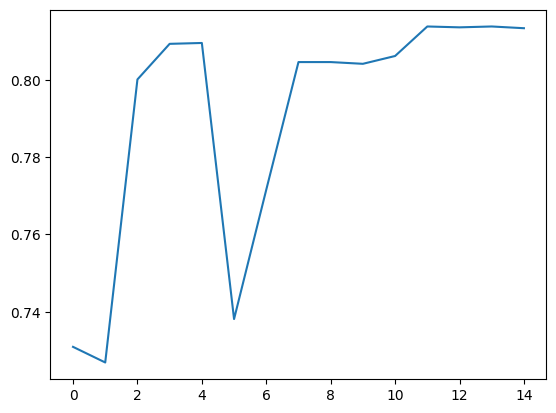

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [1]:
model.save("model_with_adversarial_training.h5")

NameError: name 'model' is not defined

In [ ]:
#WHAT IS REMAINING

# adversarial training methods
# functions to better the accuracy after adversarial training
# front-end integration

In [ ]:
#Cleverhams techniques for adversarial training
#FGSM done by Fahad
# Prject gradient descent PGD done by saba
# Basic Iterative method done by saba
# Carlini Wagner attack done by fahad
